In [8]:
# Parâmetros do modelo
valor_inicial = 1000           # valor inicial do investimento
dias = 252                     # horizonte de simulação (ex: 1 ano de pregão)
simulacoes = 10000             # número de cenários simulados
media_retorno_diario = 0.0005  # retorno médio diário (ex: 0,05%)
vol_diaria = 0.02              # volatilidade diária (2%)
graus_liberdade = 5            # quanto menor, mais "pesadas" as caudas


In [16]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt


# Baixando dados do ativo (ex: PETR4.SA)
ticker = "PETR4.SA"
dados = yf.download(ticker, start="2022-01-01", end="2024-12-31")
precos = dados["Close"]

[*********************100%***********************]  1 of 1 completed


In [26]:
print(dados)

Price           Close       High        Low       Open    Volume
Ticker       PETR4.SA   PETR4.SA   PETR4.SA   PETR4.SA  PETR4.SA
Date                                                            
2022-01-03  14.056584  14.119401  13.785987  13.790819  52704700
2022-01-04  14.109742  14.206384  13.969611  14.090413  51739200
2022-01-05  13.563711  14.143564  13.500894  14.104907  78459800
2022-01-06  13.554049  13.843975  13.452575  13.670020  61163100
2022-01-07  13.616865  13.670019  13.442909  13.583041  47507600
...               ...        ...        ...        ...       ...
2024-12-20  35.493477  35.975071  35.358631  35.792066  59277400
2024-12-23  35.503109  35.686113  35.368263  35.637955  43785600
2024-12-26  35.770000  36.000000  35.599998  35.630001  22920700
2024-12-27  35.660000  36.000000  35.610001  36.000000  24167200
2024-12-30  36.189999  36.369999  35.770000  35.779999  22355600

[749 rows x 5 columns]


In [17]:
#Calcular os retornos diários

retornos = np.log(precos / precos.shift(1)).dropna()  # log-retornos


In [18]:
# 3. Calcular média e volatilidade diária
media_retorno_diario = retornos.mean()
vol_diaria = retornos.std()

In [19]:
from scipy.stats import t

# Ajustando uma t-Student aos dados
parametros = t.fit(retornos)

graus_liberdade, loc, scale = parametros


In [20]:
# Use os parâmetros ajustados:
retornos_simulados = t.rvs(df=graus_liberdade, loc=media_retorno_diario, scale=vol_diaria, size=(dias, simulacoes))


In [21]:
# === 4. Simulação de Monte Carlo
dias = 252
simulacoes = 10000
valor_inicial = 1000

# Simular retornos com a distribuição t-Student ajustada
retornos_simulados = t.rvs(df=graus_liberdade, loc=loc, scale=scale, size=(dias, simulacoes))

# Calcular evolução do investimento
valores_simulados = valor_inicial * np.exp(np.cumsum(retornos_simulados, axis=0))


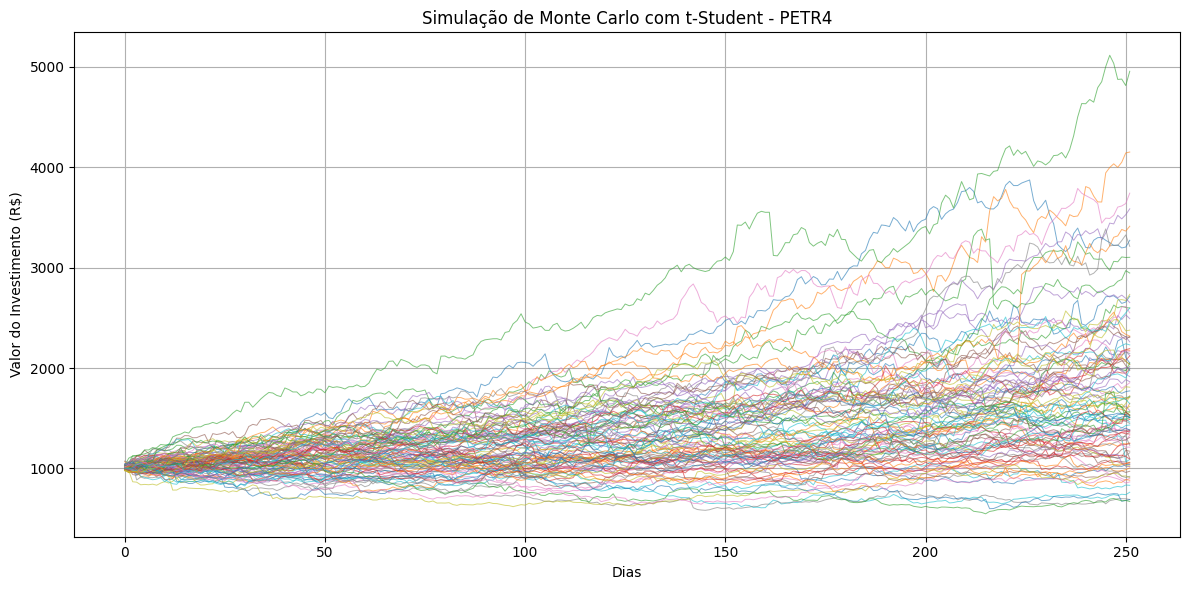


📊 Estatísticas ao final de 252 dias:
Valor médio: R$ 1744.76
Mediana: R$ 1639.54
Percentil 5% (cenário pessimista): R$ 920.89
Percentil 95% (cenário otimista): R$ 2925.85


In [28]:
# === 5. Visualização
plt.figure(figsize=(12, 6))
plt.plot(valores_simulados[:, :100], linewidth=0.7, alpha=0.6)
plt.title("Simulação de Monte Carlo com t-Student - PETR4")
plt.xlabel("Dias")
plt.ylabel("Valor do Investimento (R$)")
plt.grid(True)
plt.tight_layout()
plt.show()

# === 6. Estatísticas do resultado final
valores_finais = valores_simulados[-1, :]
print(f"\n📊 Estatísticas ao final de {dias} dias:")
print(f"Valor médio: R$ {np.mean(valores_finais):.2f}")
print(f"Mediana: R$ {np.median(valores_finais):.2f}")
print(f"Percentil 5% (cenário pessimista): R$ {np.percentile(valores_finais, 5):.2f}")
print(f"Percentil 95% (cenário otimista): R$ {np.percentile(valores_finais, 95):.2f}")


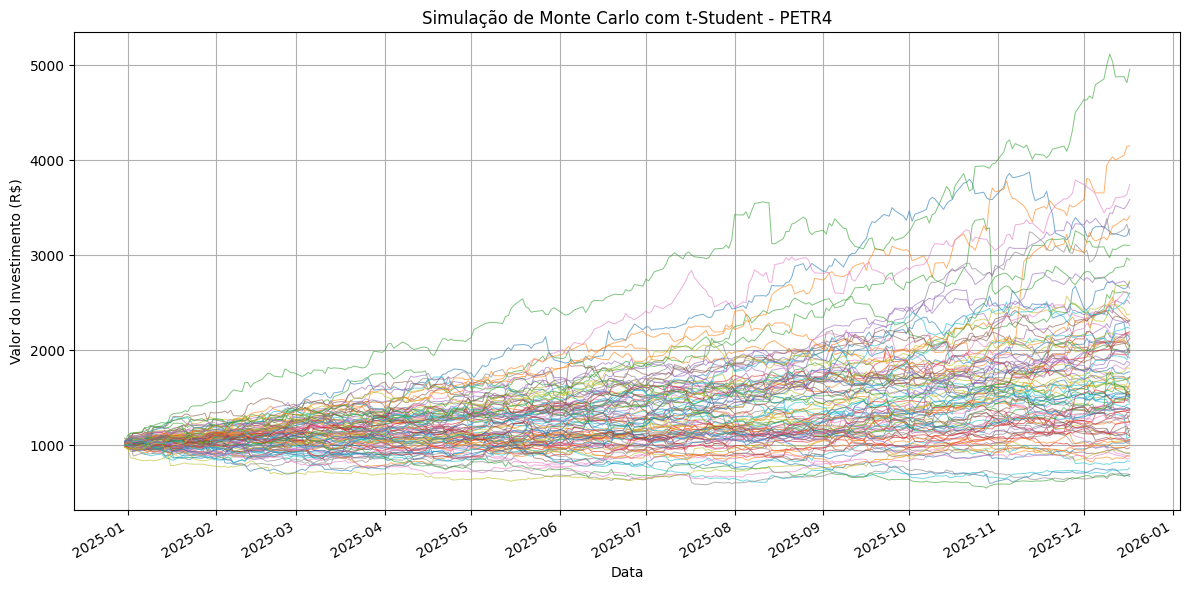

In [29]:
import pandas as pd
import matplotlib.dates as mdates

# === Criar índice de datas futuras (úteis) a partir da última data dos dados reais
data_inicio_simulacao = precos.index[-1]
datas_futuras = pd.bdate_range(start=data_inicio_simulacao + pd.Timedelta(days=1), periods=dias)

# === Gráfico com datas reais no eixo X
plt.figure(figsize=(12, 6))
plt.plot(datas_futuras, valores_simulados[:, :100], linewidth=0.7, alpha=0.6)

# Formatação do eixo de datas
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.title("Simulação de Monte Carlo com t-Student - PETR4")
plt.xlabel("Data")
plt.ylabel("Valor do Investimento (R$)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
# === 7. Cálculo do Value at Risk (VaR)
nivel_confianca = 0.95
valor_percentil = np.percentile(valores_finais, (1 - nivel_confianca) * 100)
valor_var = valor_inicial - valor_percentil  # Perda esperada

print(f"\n💥 Value at Risk (VaR) a {int(nivel_confianca*100)}% de confiança:")
print(f"VaR absoluto: R$ {valor_var:.2f}")
print(f"Valor mínimo simulado dentro da confiança: R$ {valor_percentil:.2f}")



💥 Value at Risk (VaR) a 95% de confiança:
VaR absoluto: R$ 79.11
Valor mínimo simulado dentro da confiança: R$ 920.89


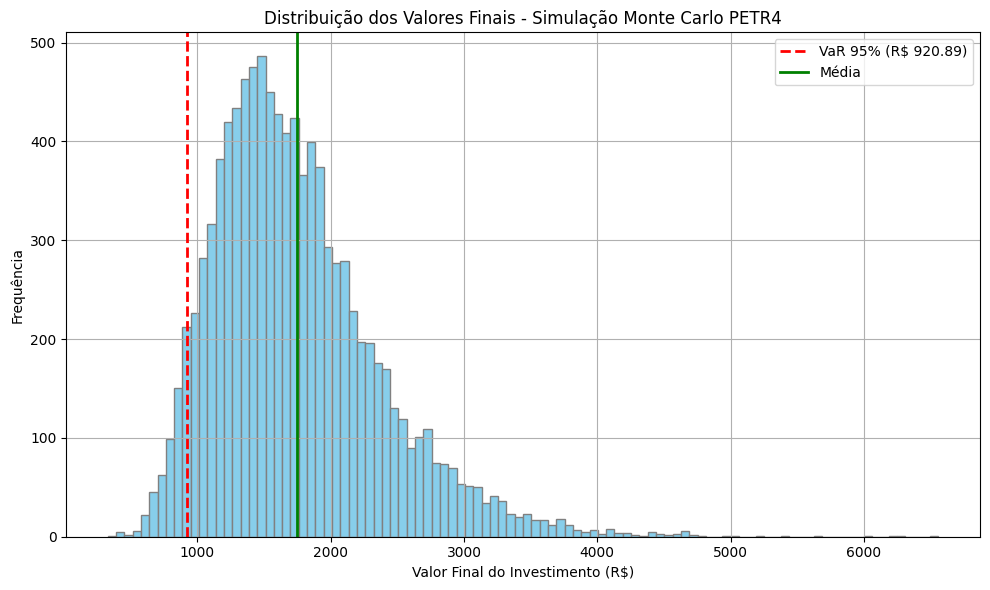

In [24]:
# === 8. Histograma com VaR marcado
plt.figure(figsize=(10, 6))
plt.hist(valores_finais, bins=100, color='skyblue', edgecolor='gray')
plt.axvline(valor_percentil, color='red', linestyle='--', linewidth=2, label=f'VaR 95% (R$ {valor_percentil:.2f})')
plt.axvline(np.mean(valores_finais), color='green', linestyle='-', linewidth=2, label='Média')
plt.title("Distribuição dos Valores Finais - Simulação Monte Carlo PETR4")
plt.xlabel("Valor Final do Investimento (R$)")
plt.ylabel("Frequência")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

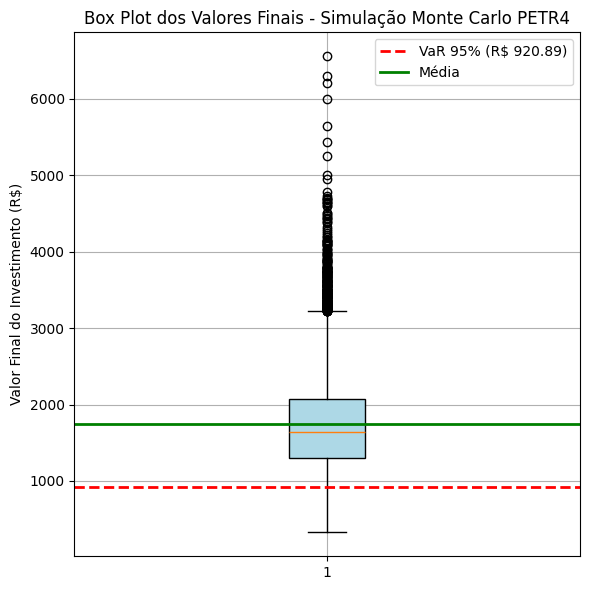

In [25]:
# === 8. Box plot com VaR
plt.figure(figsize=(6, 6))
plt.boxplot(valores_finais, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.axhline(valor_percentil, color='red', linestyle='--', linewidth=2, label=f'VaR 95% (R$ {valor_percentil:.2f})')
plt.axhline(np.mean(valores_finais), color='green', linestyle='-', linewidth=2, label='Média')
plt.title("Box Plot dos Valores Finais - Simulação Monte Carlo PETR4")
plt.ylabel("Valor Final do Investimento (R$)")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()
